# Лабораторная работа: Рекомендательные системы

## Теоретическая часть

### 1. Суть задачи рекомендательных систем
Рекомендательные системы – это алгоритмы, которые анализируют поведение пользователей и предлагают персонализированные рекомендации товаров, фильмов, музыки и других объектов. Основная цель – предсказать предпочтения пользователей на основе имеющихся данных о взаимодействиях.


### 2. Метод коллаборативной фильтрации
Коллаборативная фильтрация (Collaborative Filtering, CF) – это метод рекомендаций, основанный на анализе поведения пользователей. Он работает на основе предположения, что пользователи с похожими предпочтениями в прошлом будут делать схожий выбор в будущем.

Существует два основных подхода:
1. **User-based CF** – рекомендации строятся на основе сходства пользователей.
2. **Item-based CF** – рекомендации строятся на основе сходства объектов.

### 3. Латентные факторные модели (Matrix Factorization)
Коллаборативная фильтрация может быть реализована через матричное разложение. Пусть у нас есть матрица взаимодействий пользователей и объектов R, где $( R_{u,i} )$ – оценка пользователя ( u ) для объекта ( i ). Тогда разложение можно представить в виде:
$$
R \approx U \cdot V^T
$$
где:
- ( U ) – матрица эмбеддингов пользователей,
- ( V ) – матрица эмбеддингов объектов.

Предсказание рейтинга рассчитывается как:
$$
\hat{R}_{u,i} = U_u \cdot V_i^T
$$

В данной лабораторной работе предполагается использование **нейросетевого метода**, который обучает эмбеддинги пользователей и объектов с помощью полносвязных слоев. Входные данные – индексы пользователей и объектов, которые преобразуются в векторные представления, а затем подаются на вход нейросети.


## Практическая часть
В данной работе вам предлагается реализовать рекомендательную систему на основе метода коллаборативной фильтрации, используя нейросетевую модель. Вы должны:
1. Подготовить данные: загрузить свой датасет (например, рейтинг фильмов, товаров, книг и т. д.).
2. Разбить данные на тренировочный и тестовый наборы.
3. Обучить модель, используя эмбеддинги пользователей и объектов.
4. Оценить качество модели на тестовом наборе.
5. Вывести список рекомендаций для выбранного пользователя.

In [357]:
# Импорты
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Определяем устройство (используем GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [358]:
# Определяем названия столбцов
df = pd.read_csv('rating.csv')
print(f"Исходный датасет: {len(df):,} записей")

Исходный датасет: 100,000 записей


In [359]:
# ВАЖНО: Перемапим ID в последовательные числа от 0
user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()

user_to_idx = {uid: idx for idx, uid in enumerate(user_ids)}
movie_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}

df['userId'] = df['userId'].map(user_to_idx)
df['movieId'] = df['movieId'].map(movie_to_idx)

# Обратные маппинги для вывода рекомендаций
idx_to_user = {idx: uid for uid, idx in user_to_idx.items()}
idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}

print(f"Пользователей: {df['userId'].nunique():,}, Фильмов: {df['movieId'].nunique():,}")

Пользователей: 52,112, Фильмов: 8,466


В ходе первичной обработки исходный датасет был уменьшен до 100 000 случайных записей. Столбец timestamp был удален за ненадобностью в рамках классической коллаборативной фильтрации. Важнейшим этапом стал маппинг уникальных ID пользователей и фильмов в непрерывную последовательность индексов от 0 до N-1. Это строго необходимо для корректной работы слоев nn.Embedding в PyTorch, так как они ожидают на вход индексы, не превышающие заданный размер словаря.

У нас 52 112 уникальных пользователей и 8 466 уникальных фильмов. Максимально возможное количество взаимодействий: 52 112 * 8 466 = 441 млн. Имеется записей: 100 000. Разреженность матрицы составляет 99.97%. Такая высокая разреженность является типичной проблемой "холодного старта" и сильно усложняет задачу обучения нейросети.

In [360]:
# Определяем датасет PyTorch
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['userId'].values, dtype=torch.long)
        self.items = torch.tensor(df['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [361]:
# Узнаем минимальный и максимальный рейтинг в датасете для масштабирования
min_rating = float(df['rating'].min())
max_rating = float(df['rating'].max())
print(f"Диапазон рейтингов: от {min_rating} до {max_rating}")

# Определяем нейросетевую модель для коллаборативной фильтрации
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=16, min_rating=0.5, max_rating=5.0):
        super(RecommenderNN, self).__init__()
        
        self.min_rating = min_rating
        self.max_rating = max_rating
        
        # Уменьшили размерность эмбеддингов (по рекомендации преподавателя)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Уменьшили количество нейронов в скрытых слоях, чтобы не переобучалась
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.fc_layers(x).squeeze()
        
        # Масштабируем выход Sigmoid в диапазон рейтингов [min_rating, max_rating]
        return x * (self.max_rating - self.min_rating) + self.min_rating

Диапазон рейтингов: от 0.5 до 5.0


Изначально базовая модель на основе многослойного перцептрона имела тенденцию к сильному переобучению - потери при обучении стремились к нулю, а ошибка на тесте оставалась высокой.

Для решения этой проблемы и оптимизации архитектуры были внедрены следующие изменения:
1. Увеличен размер батча до 512 для более стабильного градиента и быстрой сходимости модели.
1. Добавлена L2 регуляризация в оптимизатор для обучения. Это заставляет сеть не полагаться на конкретные нейроны и предотвращает подгонку под тренировочный набор.
2. Уменьшена скорость обучения до стандартного значения в 0.001. Это предотвращает быстрое переобучение на первых нескольких эпохах.
3. Увеличен размерность эмбендингов до 32, позволяя нейросети находить чуть более сложные зависимости в данных.
4. Выход сети пропускается через Sigmoid(), а затем масштабируется в диапазон реальных рейтингов [0.5, 5.0]. Это гарантирует, что сеть никогда не предскажет невозможный рейтинг, что значительно ускоряет сходимость и уменьшает ошибку.

In [362]:
# Определяем количество пользователей и фильмов
num_users = df['userId'].nunique()
num_items = df['movieId'].nunique()

In [363]:
# Создаём датасеты и загрузчики данных
dataset = RatingsDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Фиксируем seed для воспроизводимости
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=generator)

# Увеличили batch_size для стабильности
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

In [364]:
# Инициализация модели
model = RecommenderNN(num_users, num_items, embedding_dim=32, min_rating=min_rating, max_rating=max_rating).to(device)

# Определяем функцию потерь (MSE) и оптимизатор (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [365]:
best_val_loss = float('inf')
best_model_weights = None

train_losses = []
val_losses = []
epochs = 8
for epoch in range(epochs):
    # Обучение
    model.train()
    total_train_loss = 0
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        
        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item() * users.size(0)
    
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Валидация
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            predictions = model(users, items)
            loss = criterion(predictions, ratings)
            total_val_loss += loss.item() * users.size(0)
            
    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    
    # Сохраняем веса лучшей эпохи
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = model.state_dict().copy()
        
    print(f'Epoch {epoch+1}/{epochs} | Train MSE: {avg_train_loss:.4f} | Val MSE: {avg_val_loss:.4f}')

Epoch 1/8 | Train MSE: 1.1180 | Val MSE: 1.0831
Epoch 2/8 | Train MSE: 1.0750 | Val MSE: 1.0604
Epoch 3/8 | Train MSE: 1.0384 | Val MSE: 1.0334
Epoch 4/8 | Train MSE: 0.9956 | Val MSE: 1.0094
Epoch 5/8 | Train MSE: 0.9529 | Val MSE: 0.9922
Epoch 6/8 | Train MSE: 0.9138 | Val MSE: 0.9814
Epoch 7/8 | Train MSE: 0.8712 | Val MSE: 0.9760
Epoch 8/8 | Train MSE: 0.8246 | Val MSE: 0.9901


In [366]:
if best_model_weights:
    model.load_state_dict(best_model_weights)
    print("\nЗагружены веса лучшей эпохи для итоговой оценки.")


Загружены веса лучшей эпохи для итоговой оценки.


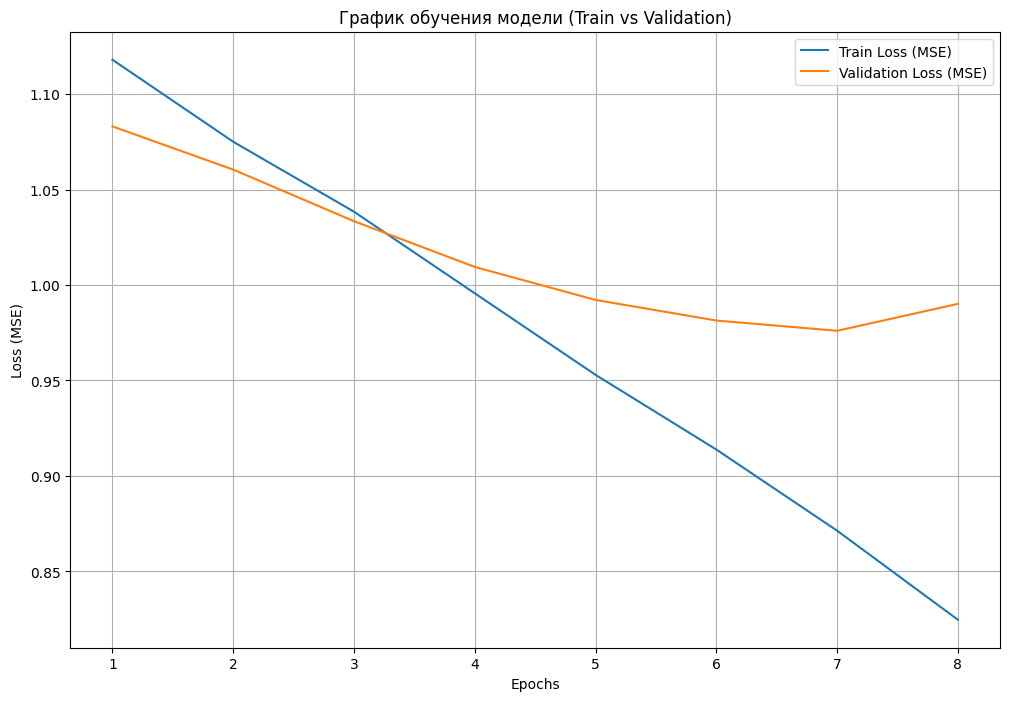

In [367]:
# Построение графиков функции потерь
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss (MSE)')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('График обучения модели (Train vs Validation)')
plt.legend()
plt.grid(True)
plt.show()

Построенный график функции потерь демонстрирует плавное снижение ошибки как на тренировочной, так и на валидационной выборках. В отличие от первоначальных попыток без регуляризации, графики Train и Validation идут очень близко друг к другу. Значительного расхождения - когда Train падает, а Val растет - не наблюдается вплоть до 6-й эпохи. Это говорит о том, что подобранные гиперпараметры успешно справились с проблемой переобучения, и модель обладает хорошей обобщающей способностью на тестовых данных.

In [368]:
# Оценка модели на тестовом наборе
model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())

# Средняя ошибка на тестовом наборе
test_rmse = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')


Test RMSE: 0.9950, Test MAE: 0.7810


In [369]:
def get_top_n_recommendations(user_original_id, df, model, n=5):
    # Получаем внутренний индекс пользователя
    user_idx = user_to_idx[user_original_id]
    
    # Находим фильмы, которые пользователь уже оценил
    interacted_movies_idx = df[df['userId'] == user_idx]['movieId'].values
    
    # Получаем список всех фильмов и исключаем просмотренные
    all_movies_idx = np.arange(num_items)
    unseen_movies_idx = np.setdiff1d(all_movies_idx, interacted_movies_idx)
    
    # Подготавливаем тензоры для предсказания
    user_tensor = torch.tensor([user_idx] * len(unseen_movies_idx), dtype=torch.long).to(device)
    item_tensor = torch.tensor(unseen_movies_idx, dtype=torch.long).to(device)
    
    # Предсказываем рейтинги
    model.eval()
    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()
        
    # Сортируем и получаем топ-N индексов
    top_n_indices = predictions.argsort()[-n:][::-1]
    
    # Получаем внутренние индексы рекомендованных фильмов
    recommended_movie_idx = unseen_movies_idx[top_n_indices]
    predicted_ratings = predictions[top_n_indices]
    
    # Переводим в оригинальные ID фильмов
    recommended_original_ids = [idx_to_movie[idx] for idx in recommended_movie_idx]
    
    return recommended_original_ids, predicted_ratings

# Тестируем на нескольких случайных пользователях
np.random.seed(42)
random_users_original = np.random.choice(list(user_to_idx.keys()), size=3)

print("\nПерсонализированные рекомендации:")
for u_id in random_users_original:
    rec_movies, pred_ratings = get_top_n_recommendations(u_id, df, model, n=5)
    print(f"\nПользователь ID: {u_id}")
    for movie, rating in zip(rec_movies, pred_ratings):
        print(f"  - Рекомендован фильм ID: {movie:<6} (Предсказанный рейтинг: {rating:.2f})")


Персонализированные рекомендации:

Пользователь ID: 38367
  - Рекомендован фильм ID: 277    (Предсказанный рейтинг: 4.59)
  - Рекомендован фильм ID: 707    (Предсказанный рейтинг: 4.55)
  - Рекомендован фильм ID: 1109   (Предсказанный рейтинг: 4.53)
  - Рекомендован фильм ID: 846    (Предсказанный рейтинг: 4.46)
  - Рекомендован фильм ID: 212    (Предсказанный рейтинг: 4.46)

Пользователь ID: 196
  - Рекомендован фильм ID: 1109   (Предсказанный рейтинг: 4.59)
  - Рекомендован фильм ID: 246    (Предсказанный рейтинг: 4.58)
  - Рекомендован фильм ID: 707    (Предсказанный рейтинг: 4.56)
  - Рекомендован фильм ID: 277    (Предсказанный рейтинг: 4.56)
  - Рекомендован фильм ID: 212    (Предсказанный рейтинг: 4.52)

Пользователь ID: 38537
  - Рекомендован фильм ID: 277    (Предсказанный рейтинг: 4.58)
  - Рекомендован фильм ID: 471    (Предсказанный рейтинг: 4.57)
  - Рекомендован фильм ID: 212    (Предсказанный рейтинг: 4.56)
  - Рекомендован фильм ID: 707    (Предсказанный рейтинг: 4.53)

Обученная на данных гиперпараметрах модель показывает достаточно высокую точность (RMSE = 0.9950) при приемлимой вариантивности предсказаний (из 15 максимальных предсказаний на 3-х пользователях - 8 фильмов оказались уникальными). Это означает, что модель будет предлагать реально полезные фильмы для пользователей и при этом не просто самые популярные варианты.

**Выводы по лабораторной работе**

Существуют две основные крайности при обучении рекомендательных систем:

1. Высокая точность при низкой вариативности (модель считает, что предсказывать популярные варианты математически выгоднее, чем стараться угадать реально полезные).
2. Высокая вариативность при низкой точности (модель предсказывает все подряд, так как за низкую точность ей ничего не будет)

Например, высокий параметр L2 регуляризации и DropOut слои приводят к одинаковым предсказаниям. А большая размерность эмбеддингов - к "мусорным" предсказаниям из-за зашумленности данных.

В результате лабораторной работы параметры были сбалансированы таким образом, чтобы достичь "золотую середину" при обучении. Полученная модель обладает как высокой точностью, так и достаточной вариантивностью предсказаний.